GitHub: https://github.com/vidisha04/02467-CSS.git
Group Members:
* Vidisha Sinha: s204081
* Mads Andersen: s204137

# Part 1 - Webscraping the 2019 poster and oral presentations
Now we hav to scrape the two sessions both the oral and poster, at the same time the following questions will be answered:
1) Inspect the HTML of the pages above and use web-scraping to get the set of participants in 2019. Share your code and add comments to guide us through it.
2) How many unique researchers you got in 2019?
3) Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice? How might your decision impact the final number of authors?

In [17]:
#Imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm.notebook import tqdm
import json
import yaml

### Scraping the oral presentations
For this session it can be seen from the html that each presentation is marked with the <br> tag, for finding every presentation the ``soup.findall()´´  function can be used.

In [2]:
url = "https://2019.ic2s2.org/oral-presentations/"
response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")

researchers = soup.find_all("br")
researchers = [i.previous_sibling for i in researchers]

print(researchers)
researchers = researchers[9:] #Some tags in the beginning are included which can simply be cut out

[<strong>Rooms per track during main conference</strong>, ' Keynotes', ' Track A', ' Track B (except 1B on Thu)', ' Track C', ' Track D (except 1D & 2D on Thu)', ' Track E', ' Track F', ' – Thursday July 18, 11:00 – 12:30 ', <em>Chair: Ziv Epstein</em>, '11:00 – 11:15 – Jieyu Ding, Qiusi Sun, Jingwen Zhang. Classifying and Understanding the Semantic Structures of Vaccine Misinformation on Twitter', '11:15 – 11:30 – Mahmoudreza Babaei, Juhi Kulshrestha, Abhijnan Chakraborty, Elissa M. Redmiles, Meeyoung Cha, Krishna Gummadi. Analyzing Biases in Perception of Truth in News Stories and Their Implications for Fact Checking', '11:30 – 11:45 – Alexandre Bovet, Hernan Makse. Dynamics and influence of misinformation and traditional fact-based news in Twitter', '11:45 – 12:00 – Ziv Epstein, Mohsen Mosleh, Antonio Arechar, Gordon Pennycook, David Rand. Primed for accuracy: A cognitive approach to fighting misinformation on Twitter', '12:00 – 12:15 – Sunandan Chakraborty, Tarunima Prabhakar, Joyo

Now some formatting have to be doen by splitting on punctuations "." and dashes "-". Also in the last line of the code block we have to go from list of lists to just one list, simutaniously one can remove any whitespaces that may occur in befor each author.

In [3]:
d = [str(i).split('.') for i in researchers]
d = [i[0] for i in d]
d = [i.split(' – ') for i in d]

dt = []
for i in d:
  for j in i:
    if ':' not in j and j != '':
      dt.append(j)

d = [i.split(',') for i in dt]
d = [item[1:] if item[0] == ' ' else item for sublist in d for item in sublist]
d = list(set(d)) # In order to remove duplicates a set of the list can be used

In [4]:
len(d) #Check the length of the author list

477

Now check if it looks right. We see that some titles are in the author data-set, because of this we can make the assumption that if any "author-name" is longer than 4 words we take it as a title.

In [5]:
oral_presenters = d.copy()

In [6]:
name_length = lambda x: len(x.split(' '))

oral_presenters = [name for name in oral_presenters if name_length(name) < 4]

Now check if the list again

### Scraping the poster session
For this html 

In [8]:
url = "https://2019.ic2s2.org/posters/"
response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")

researchers = soup.find_all("li")
researchers = [i.text.strip().replace("\n", "").replace("\t", "") for i in researchers if i.find("span")]

print(researchers)

['Program Program overviewAll keynotes & panelsAll oral presentationsAll poster presentationsAll tutorials', 'Warmup General informationJob FairDatathon', 'Attending / Local info Presenter informationList of delegatesRegistration———–Conference VenueTransportationAccommodationSocial EventsChild care', 'Organizers Conference ChairsProgram CommitteePrevious Editions', 'Frank Peter Pijpers\xa0Hypothesis testing of causality between time series', 'Martin Lukac and André Grow\xa0Recruiting mechanisms on online labour markets: an agent-based model', 'Kiran Garimella, Gianmarco De Francisci Morales, Aristides Gionis and Michael Mathioudakis\xa0Political Discourse on Social Media: Echo Chambers, Gatekeepers, and the Price of Bipartisanship', 'Eaman Jahani, Peter Krafft, Yoshihiko Suhara, Esteban Moro and Alex Pentland\xa0ScamCoins, S*** Posters, and the Search for the Next Bitcoin TM : Collective Sensemaking in Cryptocurrency Discussions', 'Gabriel Murray\xa0Predicting Small Group Interaction D

In [9]:
d = [i.split('\xa0')[0] for i in researchers][4:]
d = [i.split('and') for i in d]
d = [item for sublist in d for item in sublist]
d = [i.split(',') for i in d]
d = [item for sublist in d for item in sublist if item != '']
# One last clean up for empty spaces in the end or beginnig of a word
d = [name[1:] if name[0] == ' ' else name for name in d]
# Do the same for the names ending with white space
d = [name[:-1] if len(name) >1 and name[-1] == ' ' else name for name in d]
d = list(set(d))

In [10]:
#Get the length of the list
len(d)

443

# Part 2: Getting data from the Semantic Scholar API

First load the id's which was saved into json file, and then convert it to a dictionary. Note that if the author could not be found it was simply marked it with not found, so first that will have to be sorted out of the data.

In [20]:
author_database = pd.read_json('/Users/madsandersen/CompSocialScience/02467-CSS/all_authors.json', typ='series').to_dict()

### Get the papper and the the other required entrances
We choose to do a subset due to resource limitations. However the code demonstrates how the querying could be done, given enough time. Note that there is a 100 request limitation per 5 min, which is why a counter is initialized and incremented everytime a request is made to the server. When the limitation is reached the time module is used to make the loop wait for 5 minutes. To be on the safe side the number of requests is set to 95 and 10 seconds are added to the timer pause.

Exercises which needs to be solved
1) Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not.
2) Share the code you have used to solve the exercise above. (See code cell below)
3) How long is your final Author dataframe? How long is your final Paper dataframe?


### 1)
The data-base of authors which was created, was 112,000 authors in total so this is all the authors from IC2S2 and all of their collaborators in other projects. For this exercise only a subset of size xx were considered, in order to keep the running time reasonable.

### 2) Code for generating data-sets
The following code cells generates the 3 data-sets. Above each there is a short description of what the code does.

In the first part og this, 3 dataframes are generated and the number of authors being quried for is specified in a variable. Note that that for the "Author_dataset", the author id is created as an index, this is just to keep it more manageable and can easily be converted to a column if needed.

In [21]:
# To keep the private api keep safe, we stored in a different file:
with open('api_key.yaml') as f:
    api_key = yaml.safe_load(f)

In [22]:
n_authors = 10000
api_key = api_key['api_key']
Author_dataset = pd.DataFrame(index = list(author_database.keys())[:n_authors],columns = ['name','aliases','citationCount','field'])
Ad_fields = ['name','aliases','citationCount','field']

Paper_dataset = pd.DataFrame(columns = ['paperId','title','year','DOI','citationCount','fields','authorIds'])
Abstract_dataset = pd.DataFrame(columns = ['paperId','abstract'])

The function below is a helper function for creating paper dataset, and also the abstract dataset. It loops through the collection of papers given to it, and distributes the information into the correct dataframes. Beyond this it checks if the paper already exists in the data-set such that replicas are avoided. Some of the fields do need to have an option for a none value, since the api will not return anything if the field does not exist for the author. For the author ids a list is made of all the authors, and the it is joined into a single string. This so that it becomes easier to parse to a dataframe, and since the id's are seperated with a "," it is easy to get a list of them when working with the dataframe using the .split() string method.
Another thing to mention is the fact that a dataframe is created for each row, and then appended to the final dataset.

In [24]:
def write_paper_data(papers,Abstract_dataset,Paper_dataset):
  #print('test')
   #### Paper dataset
  d = {}
  a = {}
  for i,paper in enumerate(papers):
    if paper['paperId'] not in Paper_dataset['paperId']:
      d['paperId'] = paper['paperId']
      d['title'] = paper['title']
      d['year'] = paper['year']
      d['DOI'] = paper['externalIds']['DOI'] if 'DOI' in paper['externalIds'].keys() else None
      d['citationCount'] = paper['citationCount']
      d['fields'] = [r['s2FieldsOfStudy'][0]['category'] if len(r['s2FieldsOfStudy']) != 0 else None for r in papers]
      d['authorIds'] = ','.join([au['authorId'] for au in paper['authors'] if au['authorId'] in author_database.keys()])
      df = pd.DataFrame([d])
      Paper_dataset = pd.concat([Paper_dataset,df])

    # Create the abstract data-set
    if paper['paperId'] not in Abstract_dataset['paperId']:
      a['paperId'] = paper['paperId']
      a['abstract'] = paper['abstract']
      df1 = pd.DataFrame([a])
      Abstract_dataset = pd.concat([Abstract_dataset,df1])

  return Paper_dataset.copy(),Abstract_dataset.copy()
    #df['authorIds'] = df.apply(lambda x: [author['authorId'] for author in x['authorIds']],axis = 1)
    #Paper_dataset = pd.concat([Paper_dataset,df])

The code bellow is where the query takes place, first of the fields are defined ie. what should be quired for. Next thing is to loop through all authors being considered, the query is done using their author id, the returned object is then converted into a json object so that it can be accessed as a dictionary. most of the required fields is just copy pasting them into the dataframe. However for the citation count, each authors paper has to be iterated and the citation count can be done as sum of the list of citation counts. For the most frequent field of study, all the fields of studies the author has been involved in, is made in to a list, and the most frequent element in that list is found. One more thing about the code is that is saves the dataframes to csv every 95 queries, at the same time it sleeps for 1 second in order to avoid exceeding the request limit from the api.

Note:
Our group got an api key for 100 req/sec for the semanthic scholar api. It cant be distributed so either paste in your own api-key or delete the lines with headers and as an argument in the request call. Also this limits the request frequency to 100 per 5 min, so in the time.sleep() it should wait for 5 min (see the last lines of code).

In [ ]:
#How many authors should be considered in the dataset
# Init dataset
data = {id: {} for id in list(author_database.keys())[:n_authors]}

fields = f'name,aliases,papers.title,papers.abstract,papers.year,papers.s2FieldsOfStudy,papers.citationCount,papers.paperId,papers.externalIds,papers.authors'

exception_counter = 0
query_counter = 0
total_queries = 0
for id in tqdm(list(author_database.keys())[:n_authors]):
  if id == 'not found':
    continue

  try:
    my_url = f'https://api.semanticscholar.org/graph/v1/author/{id}?fields={fields}' #BASE_URL + VERSION + RESOURCE
    params = {'authorId': id}
    headers = {"x-api-key": api_key}

    r = requests.get(my_url, params=params,headers=headers).json()
    query_counter += 1
    total_queries += 1

    #############################Author_dataset##########################################
    Author_dataset['name'][id] =  r['name']
    Author_dataset['aliases'][id] = ','.join(r['aliases']) if r['aliases'] is not None else 'None'
    Author_dataset['citationCount'][id] = sum([paper['citationCount'] for paper in r['papers']])

    # Make a placeholder, so the most frequent can be determined:
    data[id]['papers.s2FieldsOfStudy'] = [paper['s2FieldsOfStudy'][0]['category'] if len(paper['s2FieldsOfStudy']) != 0 else None for paper in r['papers']]
    freq_field = max(set(data[id]['papers.s2FieldsOfStudy']), key = data[id]['papers.s2FieldsOfStudy'].count)
    Author_dataset['field'][id] = freq_field

    ###########################Paper_dataset ##########################################
    Paper_dataset,Abstract_dataset = write_paper_data(r['papers'],Abstract_dataset,Paper_dataset)

  except:
    print(f"Exception caught for author:{id}")
    exception_counter += 1
    time.sleep(1)


  if query_counter > 95:
    #Save to csv, this is done in each iteration as a back up, makes it a little slower but ensures that data aren't lost if/when kernel times out.
    Author_dataset.to_csv('Author_dataset.csv')
    Paper_dataset.to_csv('Paper_dataset.csv')
    Abstract_dataset.to_csv('Abstract_dataset.csv')

    time.sleep(1)
    query_counter = 0

#save_path = f'data_{total_queries}.json'
#with open(save_path, 'w') as f:
#  json.dump(data, f, indent=4)

  0%|          | 0/10000 [00:00<?, ?it/s]

Exception caught for author:2149106755
Exception caught for author:40025432
Exception caught for author:144935248
Exception caught for author:39647400


KeyboardInterrupt: 

4068 authors

Read the csv file data-set created:

In [13]:
Author_dataset = pd.read_csv('/Users/madsandersen/CompSocialScience/02467-CSS/Author_dataset.csv')
Author_dataset.columns = Author_dataset.columns.str.replace('Unnamed: 0','AuthorID')
Paper_dataset = pd.read_csv('/Users/madsandersen/CompSocialScience/02467-CSS/Paper_dataset.csv')

### 3)
The results below are from quering from 4068 authors in total
###### Resulting lengths:
The length of the final author dataframe is: xx
The length of the final paper dataframe is: xx

In [15]:
pd_length = len(Paper_dataset['paperId'].unique())
au_length = len(Author_dataset['AuthorID'].unique())
print(f'Length of the Paper-dataset: {pd_length}')
print(f'Length of the Auhtor-dataset: {au_length}')

Length of the Paper-dataset: 219246
Length of the Auhtor-dataset: 10000


In [14]:
Author_dataset.head()

,AuthorID,name,aliases,citationCount,field
0,3.228613e+07,Jonathan Zong,None,40.0,Art
1,1.454267e+08,J. N. Matias,"J Nathan Matias,J. Nathan Matias,Jorge Nathan ...",606.0,Computer Science
2,4.622519e+07,Josh Pollock,None,108.0,Computer Science
3,1.666685e+09,Dylan Wootton,Dylan R. Wootton,21.0,Art
4,2.795670e+06,Arvind Satyanarayan,None,2498.0,Computer Science


In [7]:
r #2606408

{'authorId': '2606408',
 'name': 'Douglas Zytko',
 'aliases': ['Doug Zytko'],
 'papers': [{'paperId': '0755a4a766ad6e888297f24a26d3e6f5f0fb7af0',
   'externalIds': {'DBLP': 'conf/cscw/DateyAZ22',
    'DOI': '10.1145/3500868.3559472',
    'CorpusId': 253385713},
   'title': 'Repurposing AI in Dating Apps to Augment Women’s Strategies for Assessing Risk of Harm',
   'abstract': 'In this paper we present emerging findings from an interview study with women in North America about how AI could be designed to prevent online dating-facilitated violence by augmenting their strategies for risk awareness. The study is motivated by gender disparities in harm through online dating, and the relative absence of dating app designs that prioritize women. Findings show that women are receptive to the notion of AI that augments their existing strategies for assessing risk of harm with meeting a particular user face-to-face. They outline various physical and non-physical harms that they attempt to reduce

In [53]:
for idx,id in enumerate(tqdm(list(author_database.keys())[:n_authors])):

  ####Author dataset
  Author_dataset['name'][id]= data[id]['name']
  Author_dataset['aliases'][id]= data[id]['aliases']
  Author_dataset['citationCount'][id]= sum(data[id]['papers.citationCount'])

  #Most frequent field
  field = max(set(data[id]['papers.s2FieldsOfStudy']), key = data[id]['papers.s2FieldsOfStudy'].count)
  Author_dataset['field'][id] = field

  #### Paper dataset
  d = {}
  a = {}
  for i,paper in enumerate(data[id]['papers.paperId']):
    d['paperId'] = paper
    d['title'] = data[id]['papers.title'][i]
    d['year'] = data[id]['papers.year'][i]
    d['DOI'] = data[id]['papers.DOI'][i]
    d['citationCount'] = data[id]['papers.citationCount'][i]
    d['fields'] = data[id]['papers.s2FieldsOfStudy'][i]
    d['authorIds'] = ','.join([a['authorId'] for a in data[id]['papers.Authors'][i] if a['authorId'] in author_database.keys()])
    df = pd.DataFrame([d])
    #df['authorIds'] = df.apply(lambda x: [author['authorId'] for author in x['authorIds']],axis = 1)
    Paper_dataset = pd.concat([Paper_dataset,df])

    # Create the abstract data-set
    if paper not in Abstract_dataset['paperId']:
      a['paperId'] = paper
      a['abstract'] = data[id]['abstract'][i]
      df1 = pd.DataFrame([a])
      Abstract_dataset = pd.concat([Abstract_dataset,df1])

  0%|          | 0/10 [00:00<?, ?it/s]

a83becaa4816161192474f1c7c98aecbc015a374
aba5722bc4b2bd5c694488a431a721fa79c2256d
ac47d785610ab432b59375f4b1c2d97379050132
fde65235dc02a0253daa911adbb10f0a25887ff2
08764a956f31ea736cb95ea01727b1bc52747770
342536c7d1d0369dff1e5e0f1d5876a8dc63042c
ed13b13e317f6fba239711be728dd802d2c9047d
bbb842e20bfb66c966683ace190eb8e42058c18c
db0cd343ceb532ae48d1e0b3e701fd606d5ddfb5
60553c277ed864f0db1181d0da55f943e0fe2bf2
a820eb290d0cbe7bd9751fcb9b1f4eb92fffa947
a83becaa4816161192474f1c7c98aecbc015a374
1d0923487aa3834b7eb9fb6e39248144c1f51f0d
2c7fdd8300e4e7720d8a117210ca26e62fd5c4f3
7d87044328939b67073e4a28a0a063319cc7e1ea
02d954ba9ac2b76b7ae8e8e582ecde521948cfcc
47af5455b2f0ae8f7ae64c683153133a06cd48c2
86f5799ee0e55fbdb6867d5880324cfbf286d20d
879425fc9b8b78956eb6333b6969723e3ca9780e
b00545a2731a3b5c06faee400dcad70472686a88
b58b73e754c5f836890a5c06e2b018ff4ac7f99c
fd4d5263e9b5d474c6f9ace8ecf22254159506f7
bc954e2ec4e10ba2249178e236e3aac99afa11c5
c828be2d531db58d919a1988e0dcd40dc4ac731b
da8c2f7225bd5c1f

In [ ]:
#How many authors should be considered in the dataset
# Init dataset
data = {id: {} for id in list(author_database.keys())[:n_authors]}

fields = f'name,aliases,papers.title,papers.abstract,papers.year,papers.s2FieldsOfStudy,papers.citationCount,papers.paperId,papers.externalIds,papers.authors'

exception_counter = 0
query_counter = 0
total_queries = 0
for id in tqdm(list(author_database.keys())[:n_authors]):
  if id == 'not found':
    continue

  try:
    my_url = f'https://api.semanticscholar.org/graph/v1/author/{id}?fields={fields}' #BASE_URL + VERSION + RESOURCE
    params = {'authorId': id}
    r = requests.get(my_url, params=params).json()
    query_counter += 1
    total_queries += 1

    #Author_dataset
    data[id]['name'] =  r['name']
    data[id]['aliases'] = ','.join(r['aliases']) if r['aliases'] is not None else 'None'
    data[id]['papers.title'] = [paper['title'] for paper in r['papers']]
    data[id]['abstract'] = [paper['abstract'] for paper in r['papers']]
    data[id]['papers.year'] = [paper['year'] for paper in r['papers']]
    data[id]['papers.s2FieldsOfStudy'] = [paper['s2FieldsOfStudy'][0]['category'] if len(paper['s2FieldsOfStudy']) != 0 else None for paper in r['papers']]
    data[id]['papers.citationCount'] = [paper['citationCount'] for paper in r['papers']]

    data[id]['papers.paperId'] = [paper['paperId'] for paper in r['papers']]
    data[id]['papers.DOI'] = [paper['externalIds']['DOI'] if 'DOI' in paper['externalIds'].keys() else 'None' for paper in r['papers']]
    data[id]['papers.Authors'] = [paper['authors'] for paper in r['papers']]

  except:
    print(f"Exception caught for author:{id}")
    exception_counter += 1
    time.sleep(60*5+10)


  if query_counter > 95:
    time.sleep(60*5+10)
    query_counter = 0

save_path = f'data_{total_queries}.json'
with open(save_path, 'w') as f:
  json.dump(data, f, indent=4)

# Part 3: Studying the Law of Large Numbers

According to the Law of Large numbers, if we have a large enough sample, the sample mean will converge to the population mean. This exercise will study this Law in relation to Standard Normal Distributions and more heavy-tailed distributions like Pareto and Log-Normal Distributions.

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style("whitegrid")
random.seed(10)

### Question 1
We start by sampling 10,000 points from a Gaussian Distribution with mean $\mu=0$ and standard deviation $\sigma=4$. This data is stored in an array $\textbf{X}$.

In [3]:
N = 10000
mu = 0
sigma = 4

X = mu + sigma*np.random.standard_normal(N)

### Question 2

Next, we plot this distribution of $\textbf{X}$ as a histogram.

In [52]:
def plot_hist(data, num_bins, label, log=False):
    """
    Function takes the data array, number of bins in histogram, and graph title as arguments.
    """
    fig, ax = plt.subplots(figsize=(10,3)) 
    n,bins,patches = ax.hist(data, bins=num_bins, color='tab:green', alpha=0.5, rwidth=0.8)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel('Value', fontsize=12)
    if log==True:
        ax.set_yscale('log')
    if log_x==True:
        ax.set_xscale('log')
    fig.suptitle(label, fontsize=18)
    plt.show()

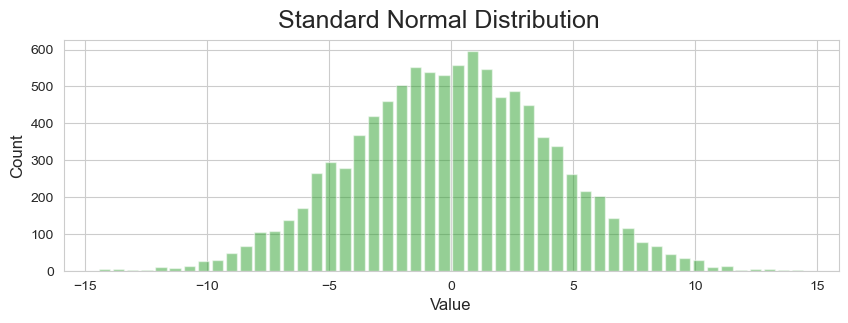

In [5]:
# The above function is used to plot the distribution of X     
plot_hist(X,50,'Standard Normal Distribution')

### Question 3

In order to show how the sample mean converges to the population mean ($\mu=0$) as sample size increases to $N=10,000$, we calculate the cummulative average of $\textbf{X}$ with increasing indices $i \in [0,N]$.

In [6]:
def find_cumm_avg(data):
    """
    This function takes a data array and finds its cummulative mean
    """
    return [np.mean(data[:i+1]) for i in range(len(data))]

In [7]:
# The above function is used to calculate the cummulative average (mean) for X
c_avg_std = find_cumm_avg(X)

### Question 4

Next, the cummulative standard error of $\textbf{X}$ is calculated for increasing indices $i \in [0,N]$. It is clear to see from the formula (and the plot in Question 6) that as the sample size increases, the standard error approaches $0$.

In [8]:
def find_std_error(data):
    """
    This function takes a data array and finds its cummulative standard error
    """
    return [np.std(data[:i+1])/np.sqrt(len(data[:i+1])) for i in range(len(data))]

In [9]:
# The above function is used to calculate the cummulative standard error for X
std_error = find_std_error(X)

### Question 5

According to the Normal Distribution's page on Wikipedia, the values of the distribution mean and median are equal to $\mu$.

In [10]:
mean = mu
median = mu

### Question 6

Now, we can plot the cummulative mean with standard error and distribution mean for $\textbf{X}$ as the sample size increases. To calculate the upper and lower bounds for the mean, the error is added and subtracted respectively from the mean, i.e., $UB = \bar{x}+\frac{err}{2}$ and $LB = \bar{x}-\frac{err}{2}$ so that the width of the error bar equals the standard error.

In [12]:
def bounds(avg, error):
    """
    This function takes the cummulative array and error value as arguments and returns upper- and lower-bound arrays.
    """
    UB = [i+(j/2) for i,j in zip(avg, error)]
    LB = [i-(j/2) for i,j in zip(avg, error)]
    return UB, LB

In [11]:
def plot(avg, UB, LB, dist_stat,label, dist_label, log_x=False, log_y=False,distb=True):
    
    """
    avg: cummulative array for a statistic 
    UB, LB: two arrays containing the upper and lower bounds on the value of the statistic 
    dist_stat: statistic value for the distribution 
    label: string containing information on the statistic being considered
    dist_label: string containing infor
    log_x,log_y: to put x/y axis a log scale
    """

    fig, ax = plt.subplots(figsize=(10,3))
    N = len(avg)

    ax.plot(UB, color='tab:orange', alpha=0.4, linewidth=1, label='Upper Bound')
    ax.plot(LB, color='black', alpha=0.4, linewidth=1, label='Lower Bound')
    ax.fill_between(np.arange(0,N),LB,UB, color='tab:red', alpha=0.2)
    
    label1 = 'Cumm. '+str(label)
    label2 = 'Dist. '+str(label)
    ax.plot(avg, linewidth=1, label=label1)
    if distb == True:
        ax.plot([dist_stat]*N, color='tab:green', alpha=0.8, linewidth=1,label=label2)

    ax.set_xlabel('Number of samples considered')
    ax.set_ylabel(label1)
    
    if log_x==True:
        ax.set_xscale('log')
    if log_y==True:
        ax.set_yscale('log')
    
    fig.legend(bbox_to_anchor=[1.06,0.8])
    label3 = 'Cummulative '+str(label)+ ' with error for '+str(dist_label)
    fig.suptitle(label3)
    plt.show()

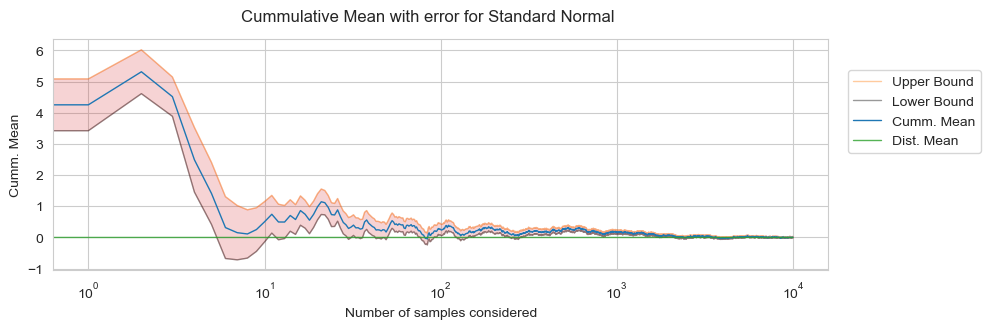

In [13]:
UB_std, LB_std = bounds(c_avg_std, std_error)
# Now we plot the graph showing the cummulative mean with error and the distribution mean
plot(c_avg_std, UB_std, LB_std, mean,'Mean', 'Standard Normal', log_x=True)

The x-axis of the plot above has been converted into a log-scale for easier visualization.

### Question 7

Next, we perform the same actions with the median statistic. First, the cummulative mean is calculated for $\textbf{X}$ for increasing indices.

In [14]:
def cumm_median(data):
    return [np.median(data[:i+1]) for i in range(len(data))]

In [15]:
c_median_std = cumm_median(X)

### Question 8

Next, the error of median is calulcated using a bootstrapping method, and the plot showing the cummulative median with its error and the distribution median is plot.

In [16]:
def med_bootstrap(data):
    """
    This function takes a data array and returns the upper and lower bounds 
    on its median statistic using bootstrapping and 90% confidence intervals.
    """
    median_error_UB = []
    median_error_LB = []

    for i in range(len(data)):
        medians = []
        j = 0
        while j <=100:
            array = np.random.choice(data[:i+1],len(data[:i+1]))
            medians.append(np.median(array))
            j +=1
        median_error_UB.append(np.percentile(medians,95)) # 90% confidence interval
        median_error_LB.append(np.percentile(medians,5))
    
    return median_error_UB, median_error_LB

In [17]:
median_error_UB_std, median_error_LB_std = med_bootstrap(X)

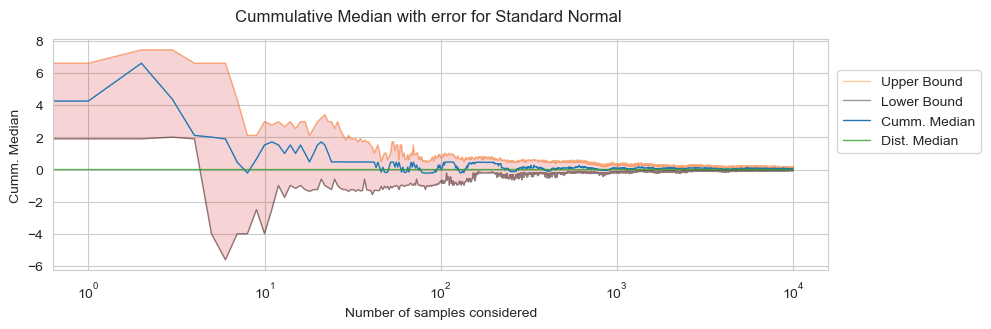

In [18]:
plot(c_median_std, median_error_UB_std, median_error_LB_std,median,'Median', 'Standard Normal',log_x=True)

The x-axis of the plot above has been converted into a log-scale for easier visualization.

### Question 9

To study the Law of Large numbers in heavy-tailed distributions, we sample the Pareto distribution.

In [19]:
N = 10000
a, m = 0.5, 1.0
P = (np.random.pareto(a, N) + 1) * m

### Question 10

This distribution is plot as a histogram where the y-axis has been given a logarithmic scale for a better visual.

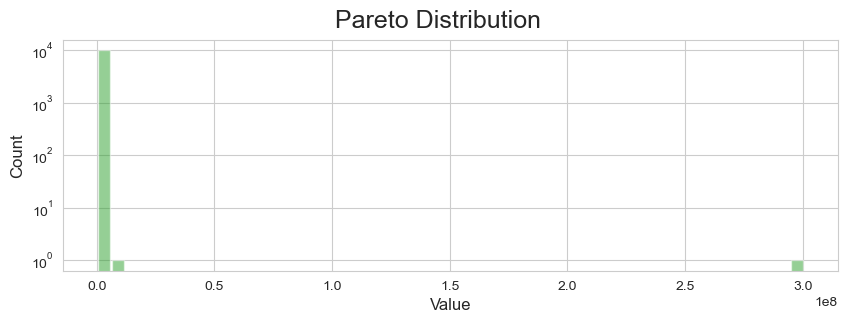

In [20]:
plot_hist(P,50,'Pareto Distribution', log=True)

The y-axis of the plot above has been converted into a log-scale for easier visualization.

Next, we find the cummulative mean and standard error of the sample mean for the Pareto distribution.

In [21]:
P_c_avg = find_cumm_avg(P)
P_std_error = find_std_error(P)

The upper and lower bounds of the mean for Pareto are calculated, and the graph with cummulative mean and error is plot. As the alpha value is less than 1, the expected mean of the distribution is equal to infinity and thus, the distribution mean is not visible in the plot.

In [22]:
UB_p, LB_p = bounds(P_c_avg, P_std_error)
P_mean = np.inf

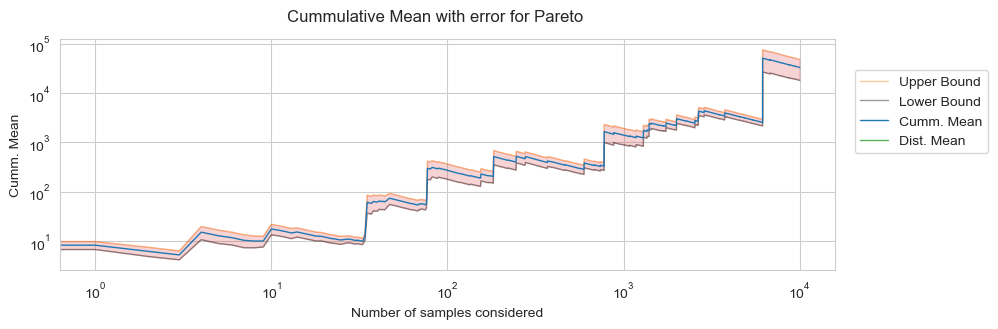

In [23]:
plot(P_c_avg, UB_p, LB_p, P_mean,'Mean','Pareto',log_x=True, log_y=True)

Both x- and y-axis of the plot above have been converted into a log-scale for easier visualization.

Next, we find the cummulative median for the distribution. To find the distribution median, the formula  $x_m\sqrt[\alpha]{2}$ is taken from Wikipedia.

In [24]:
P = np.array(P)
c_median_P = cumm_median(P)

In [25]:
median_error_UB_P, median_error_LB_P = med_bootstrap(P)

In [26]:
median_P = m*np.power(2,(1/a))

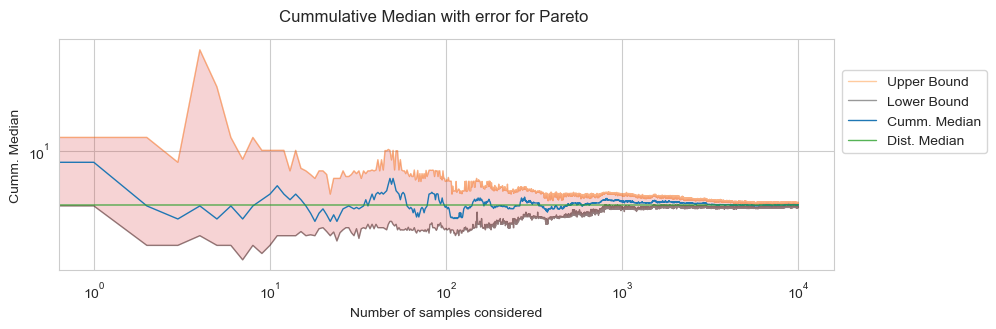

In [27]:
plot(c_median_P, median_error_UB_P, median_error_LB_P,median_P,'Median', 'Pareto', log_x=True,log_y=True)

Both x- and y-axis of the plot above have been converted into a log-scale for easier visualization.

### Question 11

Next, we sample a log-normal distribution to study another example of a heavy-tailed distribution. According to the question, we want to use numpy's np.random.standard_normal() function to create this array. In order to convert the standard normal distribution into a log-normal distribution with mean $\mu=0$ and standard deviation $\sigma=4$, we reverse Wikipedia's formula for logarithmic mean and standard deviation which are defined as $\mu_L = \exp\left(\mu+\frac{\sigma^2}{2}\right)$ and $\sigma_L=\sqrt{[\exp{(\sigma^2)}-1]\exp{(2\mu+\sigma^2)}}$ to calculate the appropriate mean and variance for the normal distributions. 

In [28]:
N = 10000
mu = 0.0000000000000000000000001 # division by zero is not possible
sigma = 4

mu_normal = np.log(mu**2 / np.sqrt(sigma**2 + mu**2))
sigma_normal = np.sqrt(np.log(1 + (sigma**2 / mu**2)))

L = np.exp(mu_normal + sigma_normal*np.random.standard_normal(N))

### Question 12

We repeat the same process as before for the log-normal distribution.

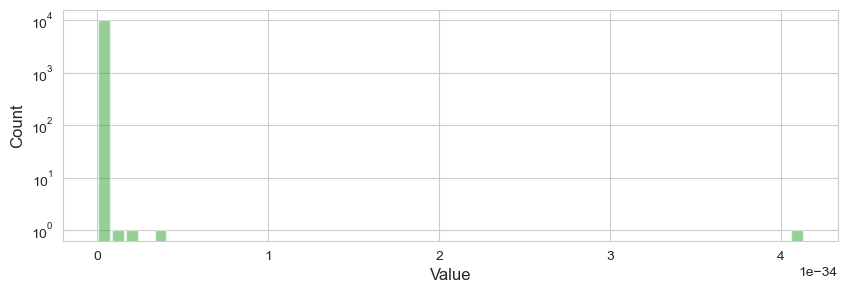

In [29]:
plot_hist(L,50,'',log=True)

The y-axis of the plot above has been converted into a log-scale for easier visualization.

The cummulative average and standard error is found using the same process as before.

In [31]:
L_c_avg = find_cumm_avg(L)
L_c_error = find_std_error(L)

As stated before, the distrbution mean is found to be $\mu_L = \exp\left(\mu+\frac{\sigma^2}{2}\right)$ for Wikipedia. Moreover, the median is found to be $med_L = \exp{(\mu)}$.

In [32]:
L_mean = np.exp(mu_normal+(sigma_normal)**2/2)
L_med = np.exp(mu_normal)

We find the bounds on the cummulative mean using the standard error function, and plot it with the distribution mean.

In [33]:
UB_L, LB_L = bounds(L_c_avg, L_c_error)

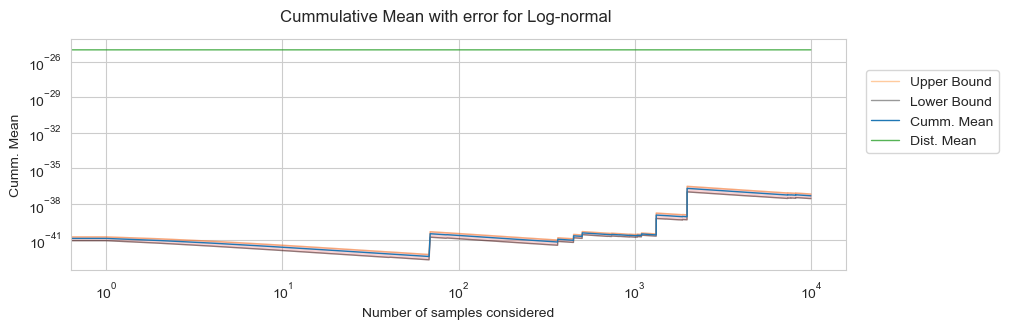

In [34]:
plot(L_c_avg, UB_L, LB_L, L_mean,'Mean','Log-normal',log_x=True, log_y=True)

Both x- and y-axis of the plot above have been converted into a log-scale for easier visualization.

Now we find the cummulative median and its upper and lower bounds.

In [35]:
L_c_med = cumm_median(L)

In [36]:
median_error_UB_L, median_error_LB_L = med_bootstrap(L)

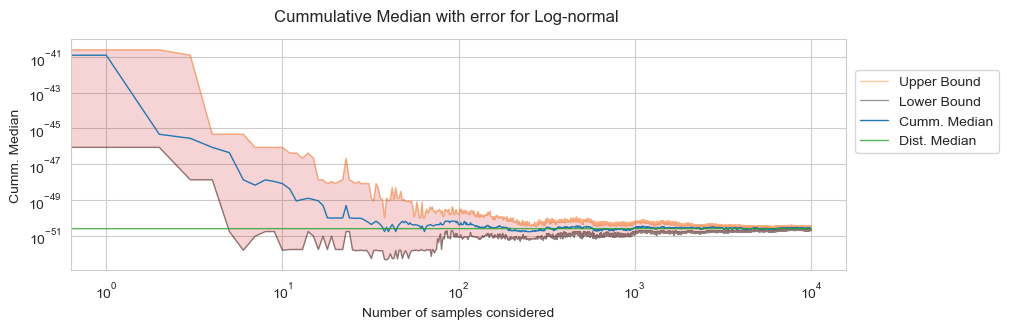

In [37]:
plot(L_c_med, median_error_UB_L, median_error_LB_L,L_med,'Median', 'Log-normal',log_x=True,log_y=True)

Both x- and y-axis of the plot above have been converted into a log-scale for easier visualization.

### Question 13

Let us consider the number of citations from papers in 2009.

In [38]:
df = pd.read_csv('C:/Users/vidis/OneDrive/Desktop/Spring23/ComputationalSocialScience/Paper_dataset.csv')
cit_array = df[(df['year']==2009)]['citationCount']

As we did not make all the API calls (due to restriction on time), we only have a sample of 8993 papers.

In [39]:
N = len(cit_array)
print('Length of array is: ',N)

Length of array is:  8993


The mean and median number of citations in this distribution are calculated using numpy and we assume a normal distribution.

In [40]:
print('Mean of number of citations is', np.round_(np.mean(cit_array),2))
print('Median of number of citations is', np.round_(np.median(cit_array),2))

Mean of number of citations is 58.81
Median of number of citations is 8.0


### Question 14

The study of the distribution is conducted for the array as well, and the y-axis of the plot above has been converted into a log-scale for easier visualization.

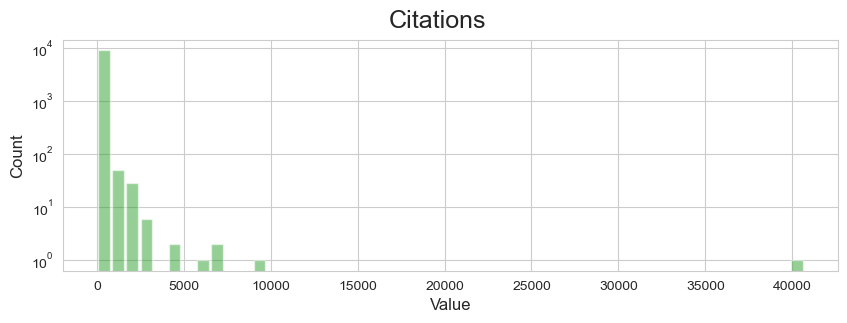

In [51]:
plot_hist(cit_array,50,'Citations',log=True)

In [43]:
C_c_avg = find_cumm_avg(cit_array)
C_c_error = find_std_error(cit_array)

We plot the cummulative mean with its error again (without considering the distribution mean).

In [44]:
UB_c, LB_c = bounds(C_c_avg, C_c_error)

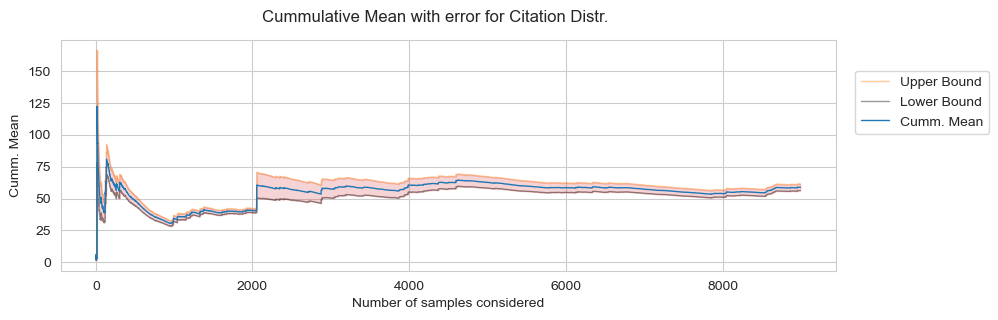

In [45]:
plot(C_c_avg, UB_c, LB_c,'','Mean', 'Citation Distr.', log_x=False, log_y=False,distb=False)

And we also plot the cummulative median with its bootstrapped error (without considering the distribution median).

In [46]:
C_c_med = cumm_median(cit_array)

In [47]:
median_error_UB_C, median_error_LB_C = med_bootstrap(cit_array)

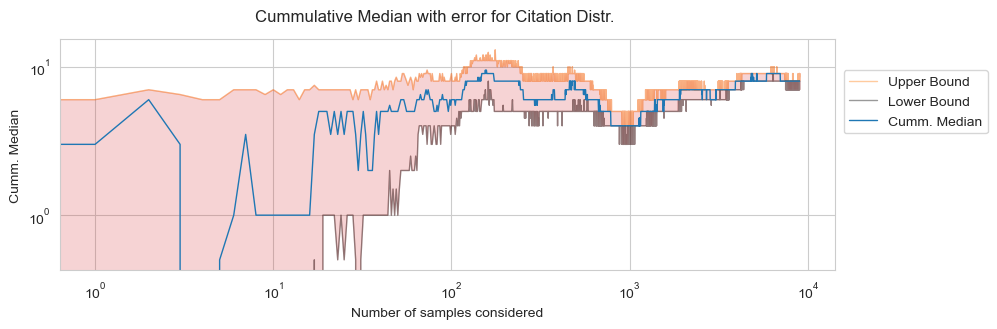

In [48]:
plot(C_c_med, median_error_UB_C, median_error_LB_C,'','Median', 'Citation Distr.', log_x=True, log_y=True,distb=False)

Both x- and y-axis of the plot above have been converted into a log-scale for easier visualization.

### Comparing evolution of cummulative mean in Gaussian, Pareto, and Log Normal Distributions

The cummulative mean graph for the Gaussian distribution shows that as the sample size increases, the cummulative mean approaches the distribution mean with a relatively smooth curve as the error approaches zero. This result is expected becayse the Gaussian distribution is a symmetric distribution with the mean acting as the central tendency of the distribution. Thus, as the sample size increases, the cummulative mean will tend towards the distribution mean.

The distribution mean of the Pareto distribution was undefined (approaches infinity for values of alpha less than 1) and due to the power-law-tail, there is a lot of variability seen in the cummulative mean plot. The graph does, however, also show a slow rise of the sample mean in the direction of the distribution mean (=positive infinity).

The cummulative mean graph for the considered Log-normal distribution show a slow rise of the cummulative mean towards the distribution mean. This is because, this distribution has a long tail towards the positive side and extreme values in the tail can have a disproportionate effect on the mean - causing it to be greater than the median. Thus, like Pareto, the log-normal distribution requires a much larger sample size for the LoLN to apply.

### Comparing evolution of cummulative median in Gaussian, Pareto, and Log-normal Distributions

The cummulative median graph shows a smooth convergence of sample median to distribution median as the sample size increases. As with cummulative mean, this is because Gaussian distribution is a symmetric distribution with median also displaying the central tendency of the distribution.

It can also be seen that the cummulative sample medians for Pareto and Log-normal distributions both converge to the distribution median values. This is because, from a statistical point of view, median is just the middle value of the distribution and is not affected by extreme values in the same way that the mean is. This is why median is accepted as a more robust measure of central tendency.

In conclusion, while working with skewed distributions, median should be prefered as a descriptive statistic over the mean.

### Studying the distribution of the citation counts

The histogram plotting the number of citations shows a power-law distribution with a right skew (also shows by the fact that the mean is relatively greater than the median).

The implication of this phenomena implies that the majority of papers get around 8 citations (using median as an indicator of central tendency) and very few papers get more than 40,000 citations. This shows the disproportionality that occurs in real-world data.

Another implication is that we're seeing a 'rich-get-richer' phenomena here as papers with a high number of citations tend to be found and cited more often - which leads to a power law emegerging. This is similar to the network example in the lectures where popularity based connections led to popular people becoming very popular and most people staying relatively unpopular.

### Summary: Take home messages of this exercise

There are two important take home messages from this exercise:

- Median should be used as an indicator of central tendency over mean when it comes to power-law/heavily skewed distributions.
- The number of citation counts of papers is an example of a real-world dataset which follows a power-law distribution because of the 'rich-get-richer' phenomenon.